In [127]:
!nvidia-smi

Tue Jun 27 15:03:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    28W /  70W |   2951MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Working with 10% of the total data**

In [128]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

In [129]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-06-27 15:03:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.253.119.128, 172.253.114.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   138MB/s    in 1.2s    

2023-06-27 15:03:21 (138 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [130]:
unzip_data('10_food_classes_10_percent.zip')

In [131]:
walk_through_dir('/content/10_food_classes_10_percent')

There are 2 directories and 0 images in '/content/10_food_classes_10_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '/content/10_food_classe

In [132]:
train_dir='/content/10_food_classes_10_percent/train/'
test_dir='/content/10_food_classes_10_percent/test/'

In [133]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [134]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [135]:
IMG_SIZE=(224,224)
BATCH_SIZE=32

In [136]:
train_data=image_dataset_from_directory(directory=train_dir,
                                        image_size=IMG_SIZE,
                                        label_mode='categorical',
                                        batch_size=BATCH_SIZE)

test_data=image_dataset_from_directory(directory=test_dir,
                                        image_size=IMG_SIZE,
                                        label_mode='categorical',
                                        batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [137]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [138]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [139]:
train_data.take

<bound method DatasetV2.take of <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>>

In [140]:
for images,labels in train_data.take(1):
  print(images,labels)

tf.Tensor(
[[[[207.66406   156.66406    77.66406  ]
   [206.85938   155.85938    74.859375 ]
   [208.85938   158.85938    73.859375 ]
   ...
   [197.2444    155.2444     97.24439  ]
   [200.        155.         98.       ]
   [200.64282   153.64282    97.64282  ]]

  [[206.66406   155.66406    76.66406  ]
   [205.15625   154.15625    73.15625  ]
   [207.15625   157.15625    72.15625  ]
   ...
   [197.8504    155.8504     97.8504   ]
   [199.60826   154.60826    97.60826  ]
   [200.7935    153.7935     97.7935   ]]

  [[204.76004   153.76004    74.76004  ]
   [203.29688   152.29688    71.296875 ]
   [204.59375   154.59375    69.29241  ]
   ...
   [199.2823    157.2823     99.28231  ]
   [199.02121   154.02121    97.02121  ]
   [200.74886   153.74886    97.748856 ]]

  ...

  [[207.84486   158.34264   100.35379  ]
   [204.7366    158.52232    98.61495  ]
   [202.44308   158.44308    95.44308  ]
   ...
   [188.20982   152.1685     82.82913  ]
   [189.10046   150.02121    72.83591  ]
   [1

In [141]:
from keras.layers.pooling.global_average_pooling2d import GlobalAveragePooling2D

base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs=Input(shape=(224,224,3),name='input_layer')

x=base_model(inputs)
print(f'Shape after passing inputs through the base model: {x.shape}')

x=GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
print(f'Shape ater Global Average Pooling: {x.shape}')

outputs=Dense(units=10,activation='softmax',name='output_layer')(x)

model=Model(inputs=inputs,outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Shape after passing inputs through the base model: (None, 7, 7, 1280)
Shape ater Global Average Pooling: (None, 1280)


In [142]:
history=model.fit(train_data,
                  epochs=5,
                  steps_per_epoch=len(train_data),
                  validation_data=test_data,
                  validation_steps=int(0.25*len(test_data)),
                  callbacks=create_tensorboard_callback(dir_name='transfer_learning',
                                                        experiment_name='10_percent_feature_extraction'))

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230627-150330
Epoch 1/5
24/24 [==============================] - 12s 213ms/step - loss: 1.9358 - accuracy: 0.3920 - val_loss: 1.3329 - val_accuracy: 0.7188
Epoch 2/5
24/24 [==============================] - 4s 140ms/step - loss: 1.1252 - accuracy: 0.7733 - val_loss: 0.9097 - val_accuracy: 0.8141
Epoch 3/5
24/24 [==============================] - 5s 176ms/step - loss: 0.8066 - accuracy: 0.8293 - val_loss: 0.7473 - val_accuracy: 0.8191
Epoch 4/5
24/24 [==============================] - 5s 178ms/step - loss: 0.6508 - accuracy: 0.8560 - val_loss: 0.6198 - val_accuracy: 0.8618
Epoch 5/5
24/24 [==============================] - 5s 178ms/step - loss: 0.5562 - accuracy: 0.8747 - val_loss: 0.5668 - val_accuracy: 0.8635


In [143]:
model.evaluate(test_data)

79/79 [==============================] - 8s 90ms/step - loss: 0.5578 - accuracy: 0.8668


[0.5577723383903503, 0.8668000102043152]

In [144]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [145]:
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_4
1 rescaling_6
2 normalization_3
3 rescaling_7
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [146]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_6 (Rescaling)        (None, None, None,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_3 (Normalization  (None, None, None,   7          ['rescaling_6[0][0]']            
 )                              3)                                                   

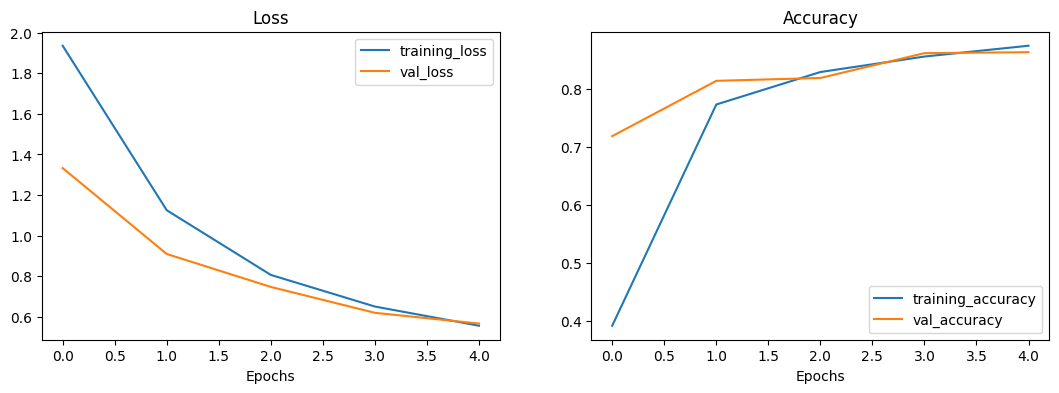

In [147]:
plot_loss_curves(history)

In [148]:
# Define input tensor shape (same number of dimensions as the output of efficientnetb0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [149]:
# Define input tensor shape (same number of dimensions as the output of efficientnetb0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"2D global max pooled random tensor:\n {global_max_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global max pooled input tensor: {global_max_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global max pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global max pooled input tensor: (1, 3)


In [150]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2023-06-27 15:04:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.234.128, 142.250.152.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.234.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M  34.4MB/s    in 3.7s    

2023-06-27 15:04:20 (34.4 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [151]:
unzip_data('10_food_classes_1_percent.zip')

In [152]:
walk_through_dir('/content/10_food_classes_1_percent')

There are 2 directories and 0 images in '/content/10_food_classes_1_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/i

In [153]:
train_dir_1p='/content/10_food_classes_1_percent/train/'
test_dir_1p='/content/10_food_classes_1_percent/test'

In [154]:
train_data_1p=image_dataset_from_directory(directory=train_dir_1p,
                                           label_mode='categorical',
                                           image_size=IMG_SIZE,
                                           batch_size=BATCH_SIZE)

test_data_1p=image_dataset_from_directory(directory=test_dir_1p,
                                        image_size=IMG_SIZE,
                                        label_mode='categorical',
                                        batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [155]:
from tensorflow.keras.layers.experimental import preprocessing

In [156]:
data_augmentation=Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
], name = 'data_augmentation')

In [157]:
import os
import random

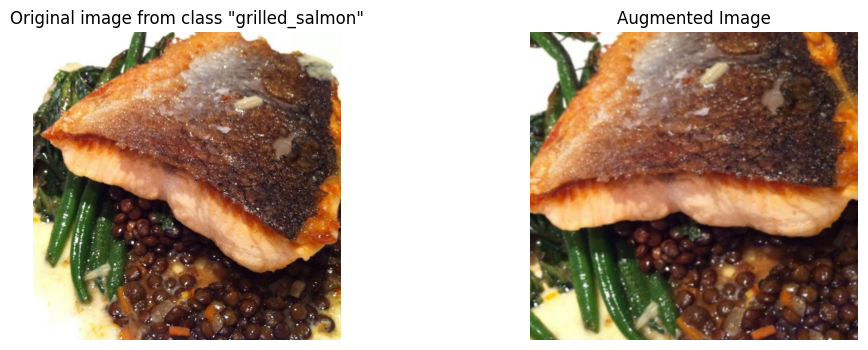

In [158]:
target_class=random.choice(train_data_1p.class_names)
target_dir='/content/10_food_classes_1_percent/train/'+target_class

random_image=random.choice(os.listdir(target_dir))
random_image_path=target_dir+'/'+random_image

img=mpimg.imread(random_image_path)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')
plt.title(f'Original image from class "{target_class}"')

augmented_image=data_augmentation(tf.expand_dims(img,axis=0))

plt.subplot(1,2,2)
plt.imshow(tf.squeeze(augmented_image)/255.)
plt.title('Augmented Image')
plt.axis(False)

plt.show()

In [159]:
def plot_original_vs_augmented_image(dir,data):

  target_class=random.choice(data.class_names)
  target_dir=dir+target_class

  random_image=random.choice(os.listdir(target_dir))
  random_image_path=target_dir+'/'+random_image

  img=mpimg.imread(random_image_path)

  plt.figure(figsize=(12,4))
  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.axis('off')
  plt.title(f'Original image from class "{target_class}"')

  augmented_image=data_augmentation(tf.expand_dims(img,axis=0))

  plt.subplot(1,2,2)
  plt.imshow(tf.squeeze(augmented_image)/255.)
  plt.title('Augmented Image')
  plt.axis(False)

  plt.show()

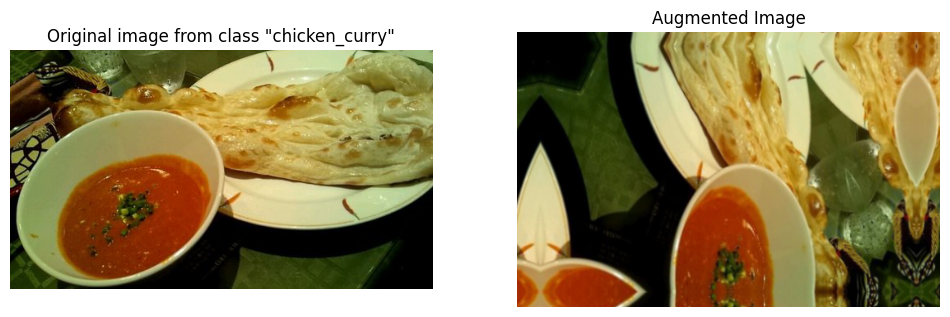

In [160]:
plot_original_vs_augmented_image(dir='/content/10_food_classes_10_percent/train/',
                                 data=train_data_1p)

In [161]:
from keras.applications import EfficientNetB0

input_shape=(224,224,3)

base_model=EfficientNetB0(include_top=False)
base_model.trainable=False

inputs=Input(shape=input_shape,name='input_layer')

x=data_augmentation(inputs)
x=base_model(x,training=False)
x=GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs=Dense(units=10,activation='softmax',name='output_layer')(x)

model1=Model(inputs=inputs,outputs=outputs)

model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [162]:
history_1_p=model1.fit(train_data_1p,
                       epochs=5,
                       steps_per_epoch=len(train_data_1p),
                       validation_data=test_data_1p,
                       validation_steps=int(0.25*len(test_data_1p)),
                       callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                             experiment_name='1_percent_data_aug')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230627-150426
Epoch 1/5
3/3 [==============================] - 12s 2s/step - loss: 2.3726 - accuracy: 0.1571 - val_loss: 2.2256 - val_accuracy: 0.1924
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1073 - accuracy: 0.2714 - val_loss: 2.0976 - val_accuracy: 0.2664
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9761 - accuracy: 0.4714 - val_loss: 1.9663 - val_accuracy: 0.3586
Epoch 4/5
3/3 [==============================] - 3s 2s/step - loss: 1.7769 - accuracy: 0.5000 - val_loss: 1.8908 - val_accuracy: 0.3898
Epoch 5/5
3/3 [==============================] - 3s 2s/step - loss: 1.6379 - accuracy: 0.6429 - val_loss: 1.7831 - val_accuracy: 0.4556


In [163]:
model1.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [164]:
model1.evaluate(test_data_1p)

79/79 [==============================] - 6s 68ms/step - loss: 1.7858 - accuracy: 0.4468


[1.7858316898345947, 0.44679999351501465]

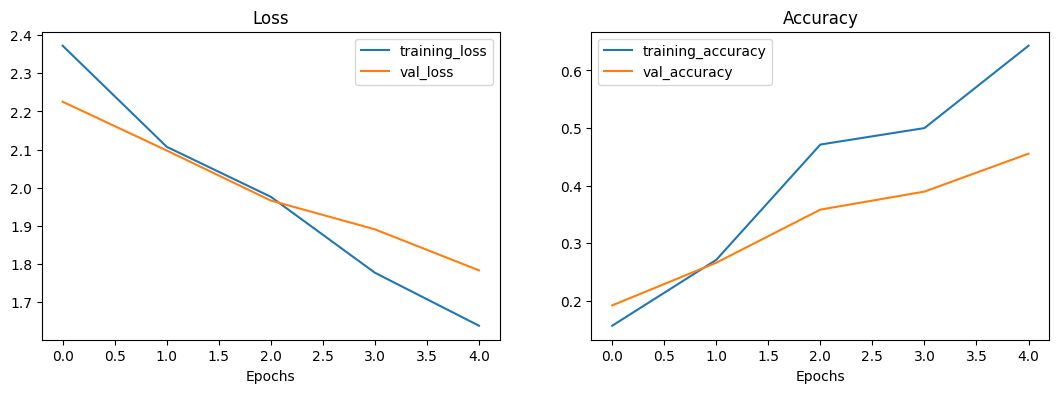

In [165]:
plot_loss_curves(history_1_p)

In [166]:
data_augmentation=Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
],name='data_augmentation')

In [167]:
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs=Input(shape=(224,224,3),name='input_layer')

x=data_augmentation(inputs)
x=base_model(x,training=False)
print(f'Shape after passing inputs through the base model: {x.shape}')

x=GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
print(f'Shape ater Global Average Pooling: {x.shape}')

outputs=Dense(units=10,activation='softmax',name='output_layer')(x)

model2=Model(inputs=inputs,outputs=outputs)

model2.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Shape after passing inputs through the base model: (None, None, None, 1280)
Shape ater Global Average Pooling: (None, 1280)


In [168]:
checkpoint_path='ten_percent_model_checkpoints_weights/checkpoint.ckpt'

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       weights_only=True,
                                                       save_best_only=False,
                                                       save_freq='epoch',
                                                       verbose=1)

In [169]:
initial_epochs=5

In [170]:
history_10_percent_data_aug = model2.fit(train_data,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)))

Epoch 1/5
24/24 [==============================] - 16s 262ms/step - loss: 1.9858 - accuracy: 0.3253 - val_loss: 1.4106 - val_accuracy: 0.6546
Epoch 2/5
24/24 [==============================] - 6s 234ms/step - loss: 1.3246 - accuracy: 0.6880 - val_loss: 0.9691 - val_accuracy: 0.7763
Epoch 3/5
24/24 [==============================] - 6s 231ms/step - loss: 1.0216 - accuracy: 0.7453 - val_loss: 0.7810 - val_accuracy: 0.7993
Epoch 4/5
24/24 [==============================] - 9s 375ms/step - loss: 0.8432 - accuracy: 0.7853 - val_loss: 0.7137 - val_accuracy: 0.8026
Epoch 5/5
24/24 [==============================] - 5s 212ms/step - loss: 0.7376 - accuracy: 0.8187 - val_loss: 0.6385 - val_accuracy: 0.8240


In [171]:
model2.evaluate(test_data)

79/79 [==============================] - 8s 95ms/step - loss: 0.6187 - accuracy: 0.8388


[0.6187387108802795, 0.8388000130653381]

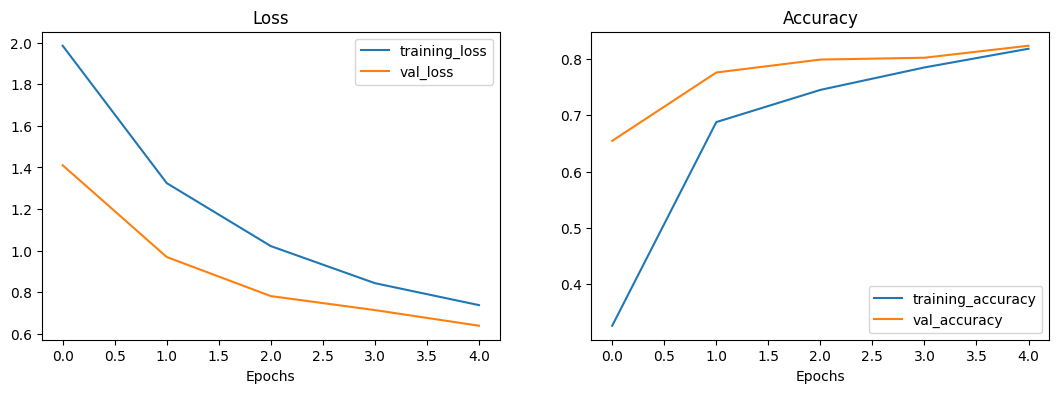

In [172]:
plot_loss_curves(history_10_percent_data_aug)

In [173]:
model2.layers

In [174]:
for layer in model2.layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f4fdd0596f0> True
<keras.engine.sequential.Sequential object at 0x7f50562195a0> True
<keras.engine.functional.Functional object at 0x7f4f3d0adf90> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f4f796e94b0> True
<keras.layers.core.dense.Dense object at 0x7f4f3d0afc40> True


In [175]:
for i,layer in enumerate(model2.layers[2].layers):
  print(layer.name,layer.trainable)

input_6 False
rescaling_10 False
normalization_5 False
rescaling_11 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2

In [176]:
base_model.trainable=True

for layer in base_model.layers[:-10]:
  layer.trainable=False

model2.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=['accuracy'])

In [177]:
fine_tune_epochs=initial_epochs+5

history_fine_tuned= model2.fit(train_data,
                               epochs=fine_tune_epochs,
                               validation_data=test_data,
                               validation_steps=int(0.25 * len(test_data)),
                               initial_epoch=history_10_percent_data_aug.epoch[-1],
                               callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                      experiment_name='fine_tune')])

Saving TensorBoard log files to: transfer_learning/fine_tune/20230627-150604


Epoch 5/10
24/24 [==============================] - 17s 313ms/step - loss: 0.6364 - accuracy: 0.8400 - val_loss: 0.4872 - val_accuracy: 0.8454
Epoch 6/10
24/24 [==============================] - 6s 241ms/step - loss: 0.5057 - accuracy: 0.8347 - val_loss: 0.4685 - val_accuracy: 0.8536
Epoch 7/10
24/24 [==============================] - 6s 239ms/step - loss: 0.4451 - accuracy: 0.8720 - val_loss: 0.4615 - val_accuracy: 0.8618
Epoch 8/10
24/24 [==============================] - 6s 213ms/step - loss: 0.3912 - accuracy: 0.8747 - val_loss: 0.4488 - val_accuracy: 0.8602
Epoch 9/10
24/24 [==============================] - 5s 174ms/step - loss: 0.3472 - accuracy: 0.9080 - val_loss: 0.4192 - val_accuracy: 0.8618
Epoch 10/10
24/24 [==============================] - 6s 228ms/step - loss: 0.3368 - accuracy: 0.9053 - val_loss: 0.4404 - val_accuracy: 0.8602


In [178]:
model2.evaluate(test_data)

79/79 [==============================] - 6s 66ms/step - loss: 0.4272 - accuracy: 0.8604


[0.42719003558158875, 0.8604000210762024]

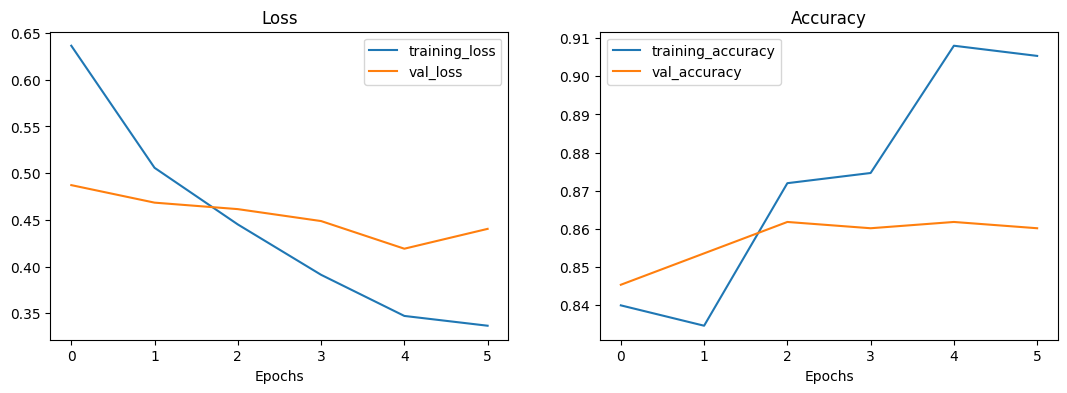

In [179]:
plot_loss_curves(history_fine_tuned)

In [180]:
# def compare_histories(original_history,new_history,initial_epochs=5):

#   acc=original_history.history['accuracy']
#   loss=original_history.history['loss']

#   val_acc=original_history.history['val_accuracy']
#   val_loss=original_history.history['val_loss']

#   total_acc=acc+new_history.history['accuracy']
#   total_loss=loss+new_history.history['loss']

#   total_val_acc=acc+new_history.history['val_accuracy']
#   total_val_loss=loss+new_history.history['val_loss']

#   plt.figure(13,4)

#   plt.subplot(1,2,1)
#   plt.plot(total_acc,label="Training Accuracy")
#   plt.plot(total_val_acc,label='Validation Accuracy')
#   plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label='Start Fine Tuning')
#   plt.legend()
#   plt.title('Training and Validation Accuracy')


def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    # print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # print(len(total_acc))
    # print(total_acc)

    # Make plots
    plt.figure(figsize=(13, 4))

    plt.subplot(1, 2, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

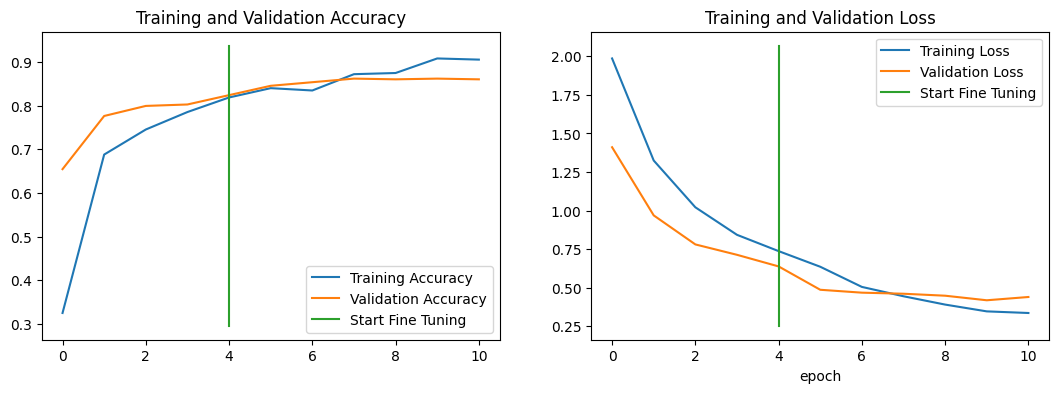

In [181]:
compare_historys(original_history=history_10_percent_data_aug,
                  new_history=history_fine_tuned,
                  initial_epochs=5)

# **Working With the Entire Data**

In [182]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2023-06-27 15:06:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.234.128, 142.250.152.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.234.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  63.2MB/s    in 6.5s    

2023-06-27 15:07:02 (76.4 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [183]:
unzip_data('10_food_classes_all_data.zip')

In [184]:
walk_through_dir(dir_path='/content/10_food_classes_all_data')

There are 2 directories and 0 images in '/content/10_food_classes_all_data'.
There are 10 directories and 0 images in '/content/10_food_classes_all_data/train'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/

In [185]:
train_dir_all_data='/content/10_food_classes_all_data/train/'
test_dir='/content/10_food_classes_all_data/test/'

In [186]:
train_data_all=image_dataset_from_directory(directory=train_dir_all_data,
                                            label_mode='categorical',
                                            image_size=IMG_SIZE)

test_data=image_dataset_from_directory(directory=test_dir,
                                       label_mode='categorical',
                                       image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [187]:
model2.evaluate(test_data)

79/79 [==============================] - 7s 81ms/step - loss: 0.4272 - accuracy: 0.8604


[0.4271901249885559, 0.8604000210762024]

In [188]:
class_names=train_data.class_names

In [189]:
base_model.trainable=True

for layer in base_model.layers[:-10]:
  layer.trainable=False

inputs=Input(shape=(224,224,3),name='input_layer')

x=data_augmentation(inputs)
x=base_model(x,training=False)
# print(f'Shape after passing inputs through the base model: {x.shape}')

x=GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
# print(f'Shape ater Global Average Pooling: {x.shape}')

outputs=Dense(units=10,activation='softmax',name='output_layer')(x)

model3=Model(inputs=inputs,outputs=outputs)

model3.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=['accuracy'])

In [190]:
history_fine_tuned_full_data=model3.fit(train_data_all,
                               epochs=fine_tune_epochs,
                               validation_data=test_data,
                               validation_steps=int(0.25 * len(test_data)))

Epoch 1/10
235/235 [==============================] - 40s 129ms/step - loss: 0.9957 - accuracy: 0.6809 - val_loss: 0.4600 - val_accuracy: 0.8553
Epoch 2/10
235/235 [==============================] - 28s 118ms/step - loss: 0.5858 - accuracy: 0.8119 - val_loss: 0.3786 - val_accuracy: 0.8717
Epoch 3/10
235/235 [==============================] - 27s 114ms/step - loss: 0.5137 - accuracy: 0.8309 - val_loss: 0.3436 - val_accuracy: 0.8914
Epoch 4/10
235/235 [==============================] - 29s 121ms/step - loss: 0.4623 - accuracy: 0.8516 - val_loss: 0.3156 - val_accuracy: 0.8931
Epoch 5/10
235/235 [==============================] - 26s 110ms/step - loss: 0.4238 - accuracy: 0.8697 - val_loss: 0.3239 - val_accuracy: 0.8964
Epoch 6/10
235/235 [==============================] - 33s 137ms/step - loss: 0.4097 - accuracy: 0.8649 - val_loss: 0.3030 - val_accuracy: 0.8947
Epoch 7/10
235/235 [==============================] - 26s 107ms/step - loss: 0.3737 - accuracy: 0.8760 - val_loss: 0.2892 - val_ac

In [191]:
model3.evaluate(test_data)

79/79 [==============================] - 6s 66ms/step - loss: 0.2628 - accuracy: 0.9144


[0.26281437277793884, 0.9143999814987183]

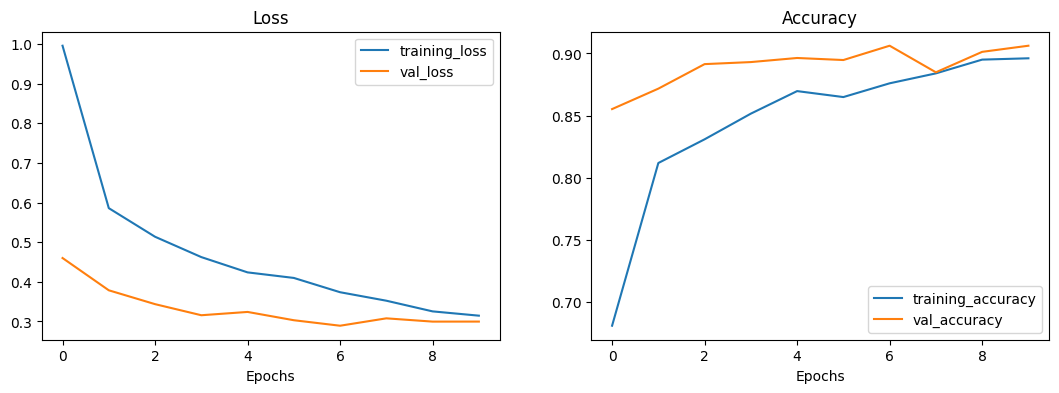

In [192]:
plot_loss_curves(history_fine_tuned_full_data)

# **Making Predictions**

In [193]:
import cv2

In [212]:
def predict(image_path,model):

  img=mpimg.imread(image_path)

  input_image=cv2.resize(img,(224,224))
  input_image=input_image.reshape(1,224,224,3)

  pred=model.predict(input_image).argmax(axis=1)[0]

  plt.imshow(img)
  plt.title(f'Prediction: {class_names[pred]}')
  plt.axis(False)
  plt.show()

1/1 [==============================] - 0s 31ms/step


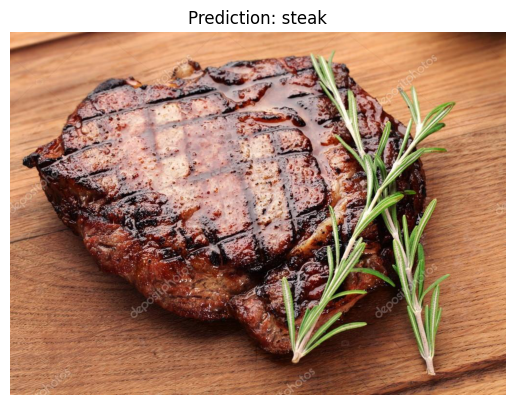

In [213]:
predict(image_path='/content/steak.jpg',model=model3)

In [196]:
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

1/1 [==============================] - 0s 65ms/step


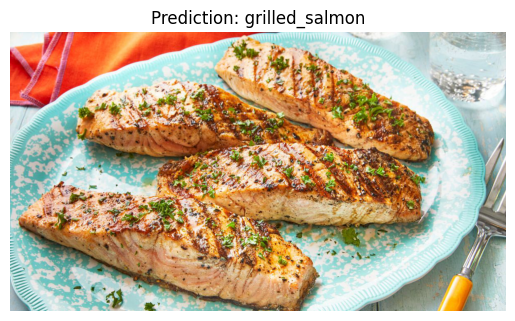

In [207]:
predict('/content/grilled_salmon.jpg',model=model3)

1/1 [==============================] - 0s 42ms/step


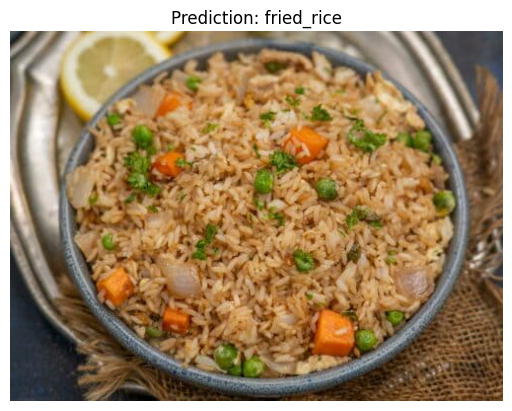

In [208]:
predict('/content/fried_rice.jpg',model=model3)

1/1 [==============================] - 0s 90ms/step


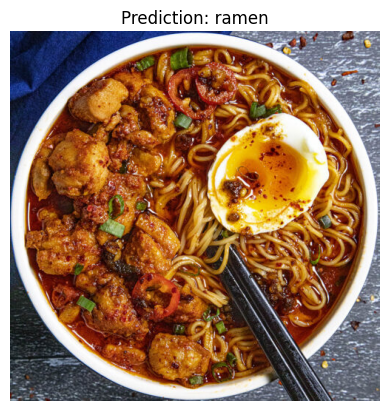

In [209]:
predict('/content/ramen.jpg',model=model3)